In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt # remove if using other plotter
from datetime import datetime # maybe can change later?
from datetime import timedelta
from scipy import stats # for percentile

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seatac-daily-weather/USW00024233.csv


In [2]:
def load_data(path):
    # reading the dataset
    data = pd.read_csv('../input/seatac-daily-weather/USW00024233.csv')
    # dropping unwanted column
    data.drop(['Unnamed: 0'], axis=1, inplace=True)
    # changing and adding date info for easier manipulation
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['month_day'] = list(zip(data.month, data.day))
    return data

In [3]:
def get_window(data, date):
    start_date = date - timedelta(days=7)
    end_date = date + timedelta(days=7)
    if start_date.month == end_date.month:
        window = data[(data['month'] == date.month) \
                      & (data['day'] >= start_date.day) \
                      & (data['day'] <= end_date.day)]
    # handles timespan going over two months
    else:
        window = data[((data['month'] == start_date.month) & (data['day'] >= start_date.day)) |\
                      ((data['month'] == end_date.month) & (data['day'] <= end_date.day))]
    return window, start_date, end_date

In [4]:
# Window history
def plot_temp_window(window, date, start_date, end_date, high, low):    
    # Can change bins to be min/max of data instead of hard coded
    sea_may_bins = np.arange(window.tmin.min(), window.tmax.max() + 1, 1)
    
    # Plotting distribution for high
    window.tmax.hist(bins=sea_may_bins,alpha=0.75, color='r')
    # Today's high and percentile
    plt.axvline(high, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(high*0.98, max_ylim*0.9, 'Today\'s High: {:.1f}'.format(high), ha='right')
    plt.text(high*0.98, max_ylim*0.8, 'Percentile: {:.1f}'.format(stats.stats.percentileofscore(window.tmax, high, 'mean')), ha='right')
    # All time 
    plt.text(window.tmax.max(), max_ylim*0.1, 'All Time High: {:.1f}'.format(window.tmax.max()), ha='center')
    plt.text(window.tmax.min(), max_ylim*0.1, 'Lowest High: {:.1f}'.format(window.tmax.min()), ha='center')
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Occurrences")
    plt.title("Daily highs for %d-%d to %d-%d" %(start_date.month,start_date.day,end_date.month,end_date.day))
    plt.savefig('highs.png')
    plt.show()
    
    # Plotting distribution for lows
    window.tmin.hist(bins=sea_may_bins,alpha=0.75, color='b')
    # Today's low and percentile
    plt.axvline(low, color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(low*1.02, max_ylim*0.9, 'Today\'s Low: {:.1f}'.format(low))
    plt.text(low*1.02, max_ylim*0.8, 'Percentile: {:.1f}'.format(100 - stats.stats.percentileofscore(window.tmin, low, 'mean')))
    # All time 
    plt.text(window.tmin.min(), max_ylim*0.1, 'All Time Low: {:.1f}'.format(window.tmin.min()), ha='center')
    plt.text(window.tmin.max(), max_ylim*0.1, 'Highest Low: {:.1f}'.format(window.tmin.max()), ha='center')
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Temperature (F)")
    plt.ylabel("Occurrences")
    plt.title("Daily lows for %d-%d to %d-%d" %(start_date.month,start_date.day,end_date.month,end_date.day))
    plt.savefig('lows.png')
    plt.show()

In [5]:
def rain(rainfall, window):
    # Getting the stats for window
    rain_rate = window['prcp'].ne(0).mean()
    avg_rainfall = window['prcp'].mean()
    avg_rainy_rainfall = window['prcp'].replace(0, np.NaN).mean()
    rain_report = open("rain_report.txt", "w")
    # printing facts
    if rainfall == 0:
        rain_report.write("There is no rain forecasted today! It rains {:.0%} of days this time of year\n".format(rain_rate))
        rain_report.write("This time of year averages {:.2f} inches of rain each day".format(avg_rainfall))
    else:
        rain_report.write("There are {:.2f} inches of rain predicted for today\n".format(rainfall))
        rain_report.write("It rains {:.0%} of days this time of year\n".format(rain_rate))
        rain_report.write("On days with rain, an average of {:.2f} inches of rain falls".format(avg_rainy_rainfall))
    rain_report.close()

In [6]:
def rain_plots(data, date, rainfall):
    dayyear = datetime.now().timetuple().tm_yday
    
    # stats for each day of the year
    rain_chance = data['prcp'].ne(0).groupby(by=data['month_day']).sum().div(data.groupby(by='month_day')['Date'].nunique())
    rain_avg = data['prcp'].groupby(by=data['month_day']).mean()
    rainy_avg = data['prcp'].replace(0, np.NaN).groupby(by=data['month_day']).mean()
    # average over 15 day window (wrapped for beginning/end of year)
    rainy_avg_wrapped = rainy_avg[(12,25):(12,31)].append(rainy_avg).append(rainy_avg[(1,1):(1,7)])
    rain_avg_wrapped = rain_avg[(12,25):(12,31)].append(rain_avg).append(rain_avg[(1,1):(1,7)])
    rain_chance_wrapped = rain_chance[(12,25):(12,31)].append(rain_chance).append(rain_chance[(1,1):(1,7)])
    # the plots
    rain_avg_windowed = rain_avg_wrapped.rolling(15, center=True, min_periods=15).mean()
    rain_avg_windowed.plot()
    rainy_avg_windowed = rainy_avg_wrapped.rolling(15, center=True, min_periods=15).mean()
    rainy_avg_windowed.plot()
    todays_rain = rain_avg_windowed[dayyear+7]
    todays_rainy = rainy_avg_windowed[dayyear+7]
    dayyear = datetime.now().timetuple().tm_yday
    plt.axvline(dayyear+7+1, color='k', linestyle='dashed', linewidth=1)
    plt.text(dayyear+7, todays_rain, 'All Days: {:.2f}'.format(todays_rain))
    plt.text(dayyear+7, todays_rainy, 'Rainy Days: {:.2f}'.format(todays_rainy))
    plt.xticks([8,40,68,99,129,160,190,221,252,282,313,343], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.ylim([0, rainy_avg_wrapped.max()])
    plt.xlim([7, 372])
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Date")
    plt.ylabel("Rainfall (Inches)")
    plt.title("Average Daily Rainfall Around Date")
    plt.legend(labels=['All Days', 'Rainy Days'])
    plt.show()
    
    # stats
    rain_chance_windowed = rain_chance_wrapped.rolling(15, center=True, min_periods=15).mean()
    rain_chance_windowed.plot()
    # using timetuple, might be helpul elsewhere? Leapyear might mess this up later
    plt.axvline(dayyear+7+1, color='k', linestyle='dashed', linewidth=1)
    plt.text(dayyear+7, rain_chance_windowed[dayyear+7], 'Current Chance: {:.0%}'.format(rain_chance_windowed[dayyear+7]))
    plt.xticks([8,40,68,99,129,160,190,221,252,282,313,343], ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.ylim([0, rain_chance_wrapped.max()])
    plt.xlim([7, 372])
    # Finishing touches
    plt.grid(axis = 'y')
    plt.xlabel("Date")
    plt.ylabel("Chance of Rain")
    plt.title("Chance of Rain in Window Around Date")
    plt.show()

In [7]:
data = load_data('../input/seatac-daily-weather/USW00024233.csv')
date = datetime.now()
window, start_date, end_date = get_window(data, date)

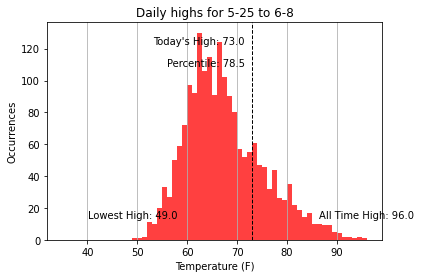

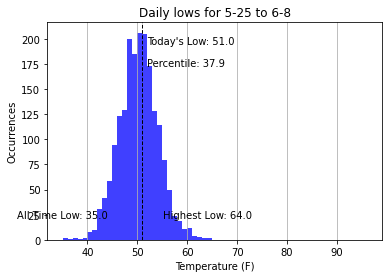

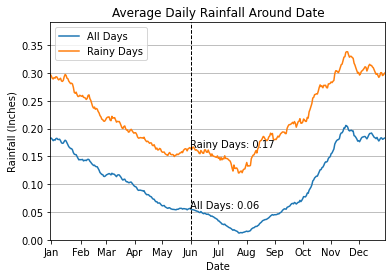

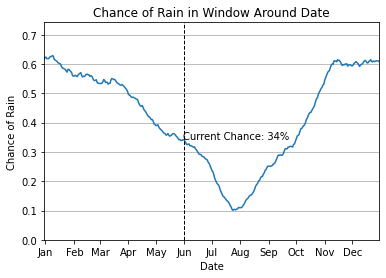

In [8]:
# input (should later get from an api for today)
high = 73
low = 51
rainfall = 0

# Plotting
plot_temp_window(window, date, start_date, end_date, high, low)
rain(rainfall, window)
rain_plots(data, date, rainfall)